# Bike Rental Analysis and Prediction

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,ShuffleSplit
from sklearn import preprocessing

%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

A lot of cities in the world are implementing bike rental stations as part of their integrated transport system. Additional to increasing the available options of moving around the city, these systems bring a lot of good consequences to urban spaces, like reducing emissions, traffic jams and improoving the health of citizens. In order to have a system working, it's important to have the correct capacity for satisfying the needs of the users.

The goal of this project is predicting the amount of bicycles needed in a city based on some temporal and weather conditions. This will let the program managers to handle their capacity, program maintenance better and keep their user rate increasing. The first part of the project is an exploratory data analysis in order to understand some of the features and variables in the dataset.

In [7]:
day = pd.read_csv('data/day.csv',sep=',')
hour = pd.read_csv('data/hour.csv',sep=',')

In [8]:
day.shape

(731, 16)

This dataset has 731 observations and 16 attributes, which 3 of them are response variables. Previous to any analysis, I will split the data and keep the test data apart, respecting the golden rule of machine learning. I decided to work with the `day` dataset, which groups the hourly observations into days.

In [9]:
day_train,day_test = train_test_split(day,test_size=0.3)

In [10]:
day_train.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
621,622,2012-09-13,3,1,9,0,4,1,1,0.612500,0.579558,0.637083,0.082721,1054,6750,7804
374,375,2012-01-10,1,1,1,0,2,1,1,0.308696,0.318826,0.646522,0.187552,173,3425,3598
44,45,2011-02-14,1,0,2,0,1,1,1,0.415000,0.398350,0.375833,0.417908,208,1705,1913
148,149,2011-05-29,2,0,5,0,0,0,1,0.667500,0.615550,0.818750,0.213938,2355,2433,4788
135,136,2011-05-16,2,0,5,0,1,1,1,0.577500,0.550512,0.787917,0.126871,773,3185,3958


### Exploratory Data Analysis

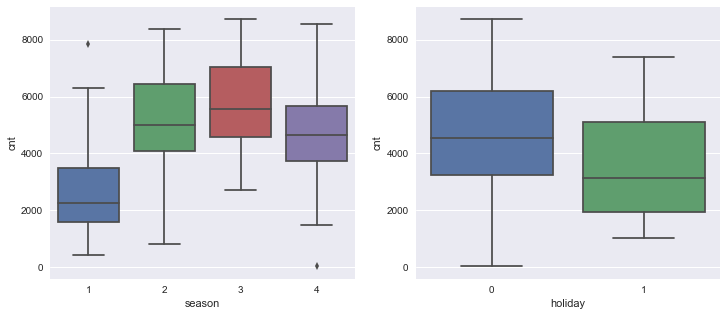

In [87]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
sns.boxplot(  y="cnt", x= "season", data=day_train,  orient='v' , ax=axes[0])
sns.boxplot(  y="cnt", x= "holiday", data=day_train,  orient='v' , ax=axes[1])
plt.show()

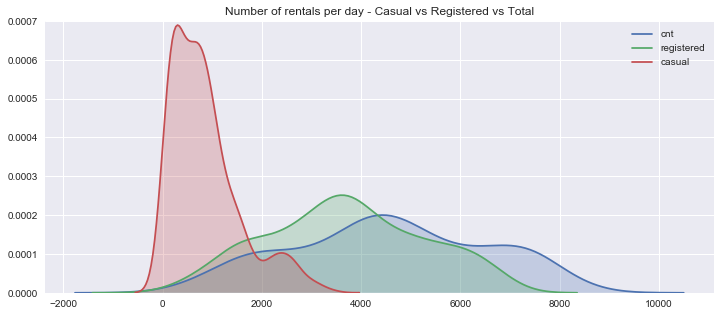

In [85]:
plt.figure(figsize=(12,5))
plt.title("Number of rentals per day - Casual vs Registered vs Total")
sns.kdeplot(day_train["cnt"], shade=True,legend=True)
sns.kdeplot(day_train["registered"], shade=True,legend=True)
sns.kdeplot(day_train["casual"], shade=True,legend=True)
plt.ylim(0,0.0007)
plt.show()

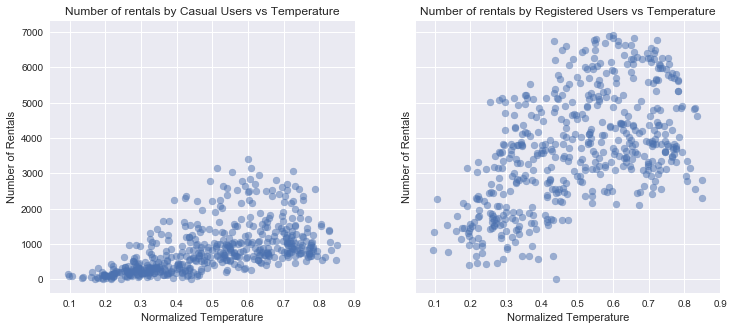

In [86]:
f, axarr = plt.subplots(1,2, sharey=True,figsize=(12,5))
axarr[0].scatter(day_train['temp'], day_train['casual'], alpha=0.5,label="Test Data")
axarr[0].set_title('Number of rentals by Casual Users vs Temperature')
axarr[0].set_xlabel('Normalized Temperature')
axarr[0].set_ylabel('Number of Rentals')
axarr[1].scatter(day_train['temp'], day_train['registered'], alpha=0.5,label="Test Data")
axarr[1].set_title('Number of rentals by Registered Users vs Temperature')
axarr[1].set_xlabel('Normalized Temperature')
axarr[1].set_ylabel('Number of Rentals')

plt.show()

In [14]:
day_train_y = day_train[['casual','registered','cnt']]

In [17]:
day_train_x = day_train[day_train.columns.difference(['casual','registered','cnt','instant'])]

In [18]:
day_train_y.describe()

,casual,registered,cnt
count,511.000000,511.000000,511.000000
mean,860.168297,3697.608611,4557.776908
std,695.752711,1572.964501,1957.390025
min,2.000000,20.000000,22.000000
25%,315.500000,2547.000000,3178.500000
50%,699.000000,3656.000000,4509.000000
75%,1133.000000,4861.000000,6146.500000
max,3410.000000,6917.000000,8714.000000


In [19]:
day_train_x.describe()

,atemp,holiday,hum,mnth,season,temp,weathersit,weekday,windspeed,workingday,yr
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.478443,0.025440,0.625206,6.418787,2.438356,0.498789,1.401174,3.052838,0.188040,0.702544,0.500978
std,0.160922,0.157613,0.139301,3.442064,1.109503,0.181176,0.540079,1.977111,0.076701,0.457587,0.500489
min,0.098839,0.000000,0.000000,1.000000,1.000000,0.096522,1.000000,0.000000,0.022392,0.000000,0.000000
25%,0.341079,0.000000,0.520000,3.000000,1.000000,0.342083,1.000000,1.000000,0.134025,0.000000,0.000000
50%,0.493046,0.000000,0.626667,6.000000,2.000000,0.506667,1.000000,3.000000,0.176617,1.000000,1.000000
75%,0.607969,0.000000,0.727291,9.000000,3.000000,0.654583,2.000000,5.000000,0.230723,1.000000,1.000000
max,0.840896,1.000000,0.972500,12.000000,4.000000,0.849167,3.000000,6.000000,0.441563,1.000000,1.000000


### Feature engineering

Some of the features in the dataset represent categories: 

### Modelling

Since the response variables in this data are numerical, the models used for explaining and predicting them should be part of the *regression* group. I will work with linear regression and will also use random forests regression, for testing both approaches.

In [ ]:
alpha_values = np.arange(0.05, 10, 0.05)
r_1 = RidgeCV(normalize=True,alphas=alpha_values)
r_1.fit(X,y)
r_1.alpha_